# This code gives a procedure that takes as its input a WeatherUnderground station ID.  It puts in a "condition request" for that station, and grabs a list of the nearby stations.  You can inductively build a data-set of all nearby stations. 


In [7]:
## this allows us to build a C-like `struct' object
from collections import namedtuple
## this allows us to load up web pages and read them
import urllib2
## this is a library for parsing JSON files.  JSON stands for JavaScript Object Notation. It
## is a common ASCII text file for describing structured data. 
import json
## we will need to put delays in between our requests to web pages.  Popular web-pages
## will block your access if you request too much data too quickly.
import time 
## for writing out own json files
import simplejson

## These routines need a Weather Underground API.  You will need to request one from the Weather Underground webpage
## to do your own scraping. If you use my one below, you will quickly be locked out. 
WAPI = "your key here"

## "WeatherStructure" is the name of this data type. 
## If X is a WStruct, you can call its attributes by: x.StationID, x.assoc, etc. 
WStruct = namedtuple("WeatherStructure", "StationID assoc neighbourhood city province country lat lon elev time weather temp_c humid wind_string wind_dir wind_deg wind_kph pressure_mb dewpt_c precip_today")
## StationID is the Wunderground station ID code
## assoc is the associated nearby Wunderground station ID's
## neighbourhood is a text string indicating roughly where the station is
## ...

In [8]:
## Give this routine a station ID, it will return a WStruct associated to the station
def FetchWeather(fStationID):
    URL_string = "http://api.wunderground.com/api/"+WAPI+"/geolookup/conditions/q/pws:"+fStationID+".json"
    print fStationID,
    URLobj = urllib2.urlopen(URL_string)
    print ". ",
    json_string = URLobj.read()
    parsed_json = json.loads(json_string) ## This creates an index for reading the file
    
    # We will use this dictionary-object to build the retval, a WStruct type. 
    adj_pws_stations = parsed_json['location']['nearby_weather_stations']['pws']['station']
    nearby_stations = [ adj_pws_stations[i]['id'] for i in range(len(adj_pws_stations)) ]
    
    # Return the WStruct
    return WStruct(StationID = fStationID, assoc = nearby_stations, neighbourhood = adj_pws_stations[0]['neighborhood'], city = parsed_json['current_observation']['display_location']['city'], province = parsed_json['current_observation']['display_location']['state_name'], country = parsed_json['current_observation']['display_location']['country'], lat = parsed_json['current_observation']['display_location']['latitude'], lon = parsed_json['current_observation']['display_location']['longitude'], elev = parsed_json['current_observation']['display_location']['elevation'], time = parsed_json['current_observation']['observation_time'], weather = parsed_json['current_observation']['weather'], temp_c = parsed_json['current_observation']['temp_c'], humid = parsed_json['current_observation']['relative_humidity'], wind_string = parsed_json['current_observation']['wind_string'],wind_dir = parsed_json['current_observation']['wind_dir'], wind_deg = parsed_json['current_observation']['wind_degrees'], wind_kph = parsed_json['current_observation']['wind_kph'], pressure_mb = parsed_json['current_observation']['pressure_mb'], dewpt_c = parsed_json['current_observation']['dewpoint_c'], precip_today = parsed_json['current_observation']['precip_today_metric'])
        


In [9]:
# Keep a list of stations we've already queried
StationsVisited = []
# And a list of stations we've discovered but not queried. We give it an initial seed.
StationsUnexplored = ["IBRITISH479"]
# List of fetched weather station data. 
WeatherStationData = []

## Run through only the *newly discovered* weather stations, and poll
## them, building the list of weather station data. 

def buildStationData():
    print "Fetching weather from station: ",
    global StationsUnexplored
    tempUnexplored = []
    for i in range(len(StationsUnexplored)):
        WS = FetchWeather(StationsUnexplored[i])
        time.sleep(6) ## be nice!
        WeatherStationData.append(WS)
        StationsVisited.append(WS.StationID)
        
        ## let's start building the new unexplored list..
        for j in range(len(WS.assoc)):
            if (WS.assoc[j] not in StationsVisited) and (WS.assoc[j] not in StationsUnexplored) and (WS.assoc[j] not in tempUnexplored):
                tempUnexplored.append(WS.assoc[j])
    print("\n")
    StationsUnexplored = list(tempUnexplored)
    

In [17]:
## This block you can execute as many times as you like, to buildup your station readings.
# on iteration, the list size grows roughly like: 1, 23, 67, 116... at which point we're 
# up in Duncan already.  At the next stage we'd be in Vancouver and Port Angeles.
buildStationData()
print("Explored: ", len(StationsVisited), "Unexplored: ", len(StationsUnexplored), "\n")


Fetching weather from station:  IBCVICTO45 .  IBCVICTO95 .  IBCVICTO28 .  IBCVICTO3 .  IBRITISH177 .  IBCVICTO61 .  IBCVICTO30 .  IBCVICTO9 .  IBCVICTO91 .  IBRITISH188 .  IBCVICTO71 .  IBCVICTO36 .  IBRITISH243 .  IBRITISH90 .  IBCVICTO89 .  IBCVICTO81 .  IBCVICTO16 .  IBCVICTO77 .  IBCVICTO41 .  IBCVICTO34 .  IBCVICTO42 .  IDNS70 .  IBCVICTO47 .  IBCVICTO11 .  IBCVICTO40 .  IBRITISH376 .  IBCVICTO83 .  IBRITISH329 .  MC4635 .  IBCNORTH29 .  IBCNORTH49 .  MAP473 .  

('Explored: ', 33, 'Unexplored: ', 31, '\n')


In [18]:
## Let's do a plot of altitude vs temperature. 
%matplotlib inline 
## the above forces figures to stay in the browser window. 
from matplotlib import *
import matplotlib.pyplot as plt

xax = [float(WeatherStationData[i].elev) for i in range(len(WeatherStationData))]
yax = [float(WeatherStationData[i].temp_c) for i in range(len(WeatherStationData))]

In [15]:
## Dump a list of 4-tuples to a file, for future linear regression
elevV = [float(WeatherStationData[i].elev) for i in range(len(WeatherStationData))]
humidV = [float(WeatherStationData[i].humid.replace("%", "")) for i in range(len(WeatherStationData))]
windspV = [float(WeatherStationData[i].wind_kph) for i in range(len(WeatherStationData))]
tempV = [float(WeatherStationData[i].temp_c) for i in range(len(WeatherStationData))]
dumpV = zip(elevV, humidV, windspV, tempV)

f = open('elev.humid.windsp.temp.Jan21.205.txt','w')
simplejson.dump(dumpV, f)
f.close()

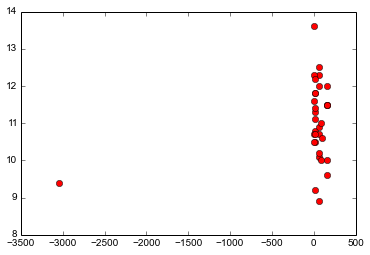

In [19]:
plt.plot(xax,yax, 'ro')
plt.show()

## As we can see, some of the elevation readings are anomalous. 
## We can delete those entries for the purpose of our graphic.
## Google has a service that estimates altitude on the earth's surface
## by lat and long coordinates.  I believe it uses satellite imagery to 
## make this determination -- this is how Google indicates the altitude
## of objects on Google earth.  So if we wanted to we could correct
## the altitudes in the above data. Google Earth's data appears to be
## accurate to only 10m.

In [20]:
rxax = [float(xax[i]) for i in range(len(xax)) if (float(xax[i])>-10.0)]
ryax = [float(yax[i]) for i in range(len(xax)) if (float(xax[i])>-10.0)]

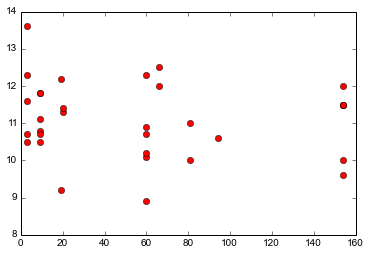

In [21]:
plt.plot(rxax,ryax, 'ro')
plt.show()

In [12]:
## We can save our data to human-readable text-file
import simplejson
f = open('temp-vs-alt.jan21.afternoon.txt','w')
simplejson.dump([xax, yax], f)
f.close()

In [23]:
## And we can load it back later. 
f = open('temp-vs-alt.jan21.afternoon.txt','r')
[l1,l2] = simplejson.load(f)

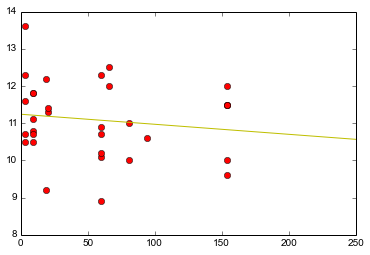

In [24]:
## Let's consider doing some basic statistical analysis of the patterns here. 
## Linear Regression (see Wikipedia) can be used to find a unique line that is
## a `best fit' for the data. This means the sum of the distances of the points from
## the `regression line' is minimal... in a fairly specific sense. 
from scipy import stats
import numpy as np
slope, intercept, r_value, p_value, std_err = stats.linregress(rxax, ryax)
plt.plot(rxax,ryax,'ro')
linfunc = intercept + rxax*slope
plt.plot([0.0, 250.0], [intercept, 250.0*slope+intercept], 'y-') ## Add the regression line
plt.show()

In [25]:
## One can as for a quantification of "how good" the above fit is. 
print("p-value: ", p_value)
print("R-value: ", r_value)
print("std_err: ", std_err)

('p-value: ', 0.42874758441816518)
('R-value: ', -0.14491465351860147)
('std_err: ', 0.0033613112434486728)


The $R$-value is defined as 
$$ R^2 = \frac{\sum_i (\hat y_i - \overline{y})^2}{\sum (y_i - \overline{y})^2}$$
where $y_i$ are the observed $y$-values, $\overline{y}$ is their mean, and $\hat y_i$ is the fitted $y$-values, i.e. the linear function above evaluated at the $x_i$ coordinates. So the $R$-value is highly scale dependent, but gives a clear idea of whether or not the predicted and measured quantities $\hat y_i$ and $y_i$ respectively have similar variation about the mean. 

The $p$-value measures confidence that the slope is horizontal, or more precisely, that there is no indication of dependence of the $y$-variable on the $x$.  It is a number between $0$ and $1$, it is $1$ when there is fair certainty the fitting line could be horizontal.  It is $0$ (or close to $0$) when there is (good) certainty the slope is non-zero and the data fits that line `well'. 